In [163]:
import sys 
sys.path.append("..")

from osgeo import gdal

import pandas as pd

import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

from tqdm import tqdm

from generate_distance_map import generate_distance_map
# load label
from skimage.measure import label, regionprops, regionprops_table

from src.logger import create_logger
from src.metrics import evaluate_metrics
from src.model import define_loader, build_model, load_weights, train, save_checkpoint
from src.multicropdataset import DatasetFromCoord
from src.utils import read_tiff,read_yaml


# from evaluation import evaluate_iteration
from pred2raster import pred2raster
from sample_selection import get_components_stats

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns

import os
import gc

from collections.abc import Iterable

In [42]:
sns.set_style("darkgrid")
# set figsize
plt.rcParams["figure.figsize"] = (8,5)

In [152]:
# dict_colors = 
# generate color palette to values from 1 to 14
dict_colors = {}

dict_colors["tree_type"] = {key:color for key,color in zip(range(1,15),sns.color_palette("tab20", 14))}

In [162]:
# how to verify if a variable is iterable

isinstance(np.array([]), )

True

In [165]:
def autolabel(ax:np.ndarray, format:str=None):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    """
    if not isinstance(ax, Iterable):
        ax = [ax]

    if format is None:
        format = "{:.0f}"
        
    for ax_ in ax:
        for rect in ax_.patches:
            height = rect.get_height()
            ax_.annotate(format.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

In [7]:
args = read_yaml("../args.yaml")

iter_folders = os.listdir(args["data_path"])

iter_folders = [f for f in iter_folders if f.startswith("iter")]

iter_folders = sorted(iter_folders, key=lambda x: int(x.split("_") [1]))

iter_folders.pop()

print(iter_folders)

['iter_1', 'iter_2', 'iter_3', 'iter_4', 'iter_5', 'iter_6', 'iter_7', 'iter_8', 'iter_9', 'iter_10', 'iter_11', 'iter_12', 'iter_13', 'iter_14', 'iter_15', 'iter_16']


In [26]:
iter_stats = []

for iter_folder in tqdm(iter_folders):
    label_path = os.path.join(args["data_path"], iter_folder, "new_labels", "all_labels_set.tif")
    
    label_img = read_tiff(label_path)

    components = label(label_image=label_img)
    
    components_stats = get_components_stats(components, label_img)
    components_stats.reset_index(inplace=True)
    
    iter_num = int(iter_folder.split("_")[1])
    
    components_stats["iter"] = f"iter_{iter_num:02d}"
    
    components_stats["iter_num"] = iter_num

    iter_stats.append(components_stats)

all_labels_stats = pd.concat(iter_stats)
all_labels_stats.shape

100%|██████████| 16/16 [01:39<00:00,  6.21s/it]


In [187]:
iter_stats = []

for iter_folder in tqdm(iter_folders):
    label_path = os.path.join(args["data_path"], iter_folder, "new_labels", "selected_labels_set.tif")
    
    label_img = read_tiff(label_path)

    components = label(label_image=label_img)
    
    components_stats = get_components_stats(components, label_img)
    components_stats.reset_index(inplace=True)
    
    iter_num = int(iter_folder.split("_")[1])
    
    components_stats["iter"] = f"iter_{iter_num:02d}"

    components_stats["iter_num"] = iter_num

    iter_stats.append(components_stats)



selected_labels_stats = pd.concat(iter_stats)
selected_labels_stats.shape

100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


(30336, 17)

In [182]:
total_area = label_img.shape[0] * label_img.shape[1]

print(f"{total_area:,.0f}")

26,562,510


# Área Total coberta

In [174]:
last_iter_stats = all_labels_stats[all_labels_stats["iter_num"]==all_labels_stats["iter_num"].max()]

print(f"Área coberta da imagem: {last_iter_stats['area'].sum()/total_area:,.2%}")

Área coberta da imagem: 18.38%


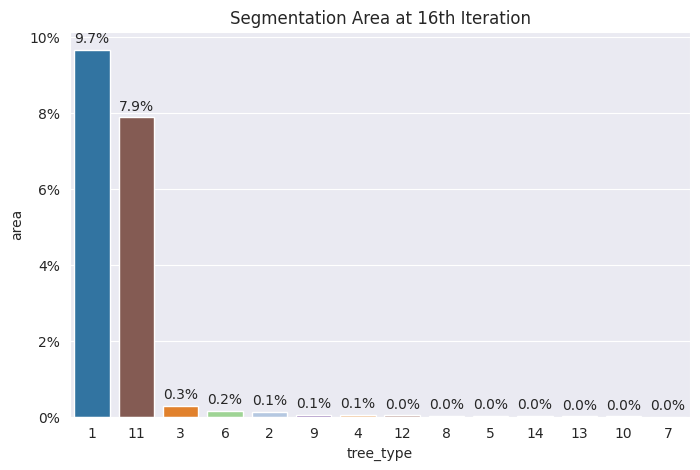

In [207]:
ax = sns.barplot(data=last_iter_stats, 
                 x="tree_type", y="area", 
                 estimator=lambda group: group.sum()/total_area, 
                 errorbar=None,
                 order=last_iter_stats.groupby("tree_type")["area"].sum().sort_values(ascending=False).index,
                 palette=dict_colors["tree_type"])

ax.set_title("Segmentation Area at 16th Iteration")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

autolabel(ax, "{:.1%}")

plt.show()

In [37]:
all_labels_stats["iter_num"] = all_labels_stats["iter"].str.split("_", expand=True)[1].astype(int)

In [71]:
total_area = label_img.shape[0]*label_img.shape[1]

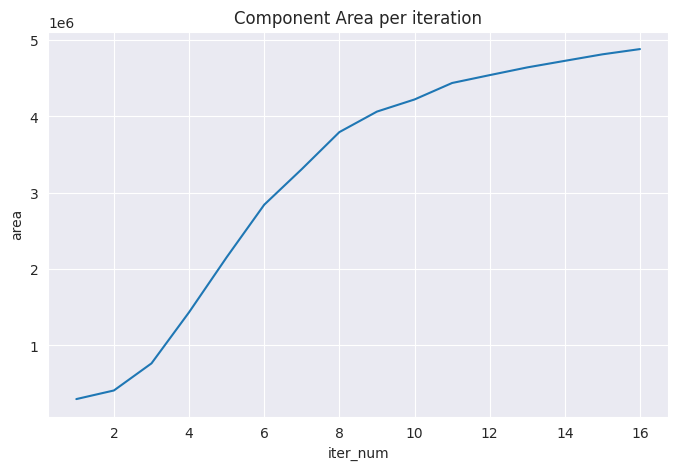

In [63]:
ax = sns.lineplot(data=all_labels_stats, x="iter_num", y="area", estimator="sum", errorbar=None)
ax.set_title("Component Area per iteration")

plt.show()

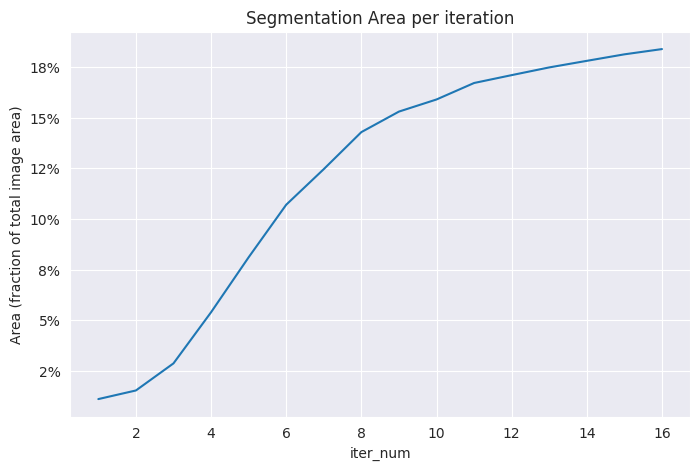

In [81]:
ax = sns.lineplot(data=all_labels_stats, x="iter_num", y="area", estimator=lambda x: x.sum()/total_area, errorbar=None)

ax.set_title("Segmentation Area per iteration")
ax.set_ylabel("Area (fraction of total image area)")

# format y ticks labels with FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.show()

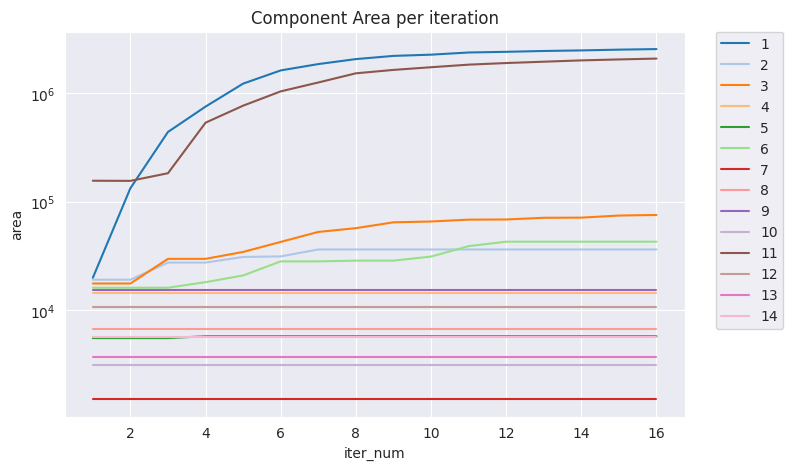

In [153]:
ax = sns.lineplot(
    data=all_labels_stats,
    x="iter_num",
    y="area",
    hue="tree_type",
    estimator="sum",
    errorbar=None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Component Area per iteration")

# set y log scale
ax.set_yscale("log")

# set outside box legend
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

# Contagem de árvores

In [194]:
print("Número total de árvores identificadas:")
print(last_iter_stats['label'].nunique())

Número total de árvores identificadas:
3617


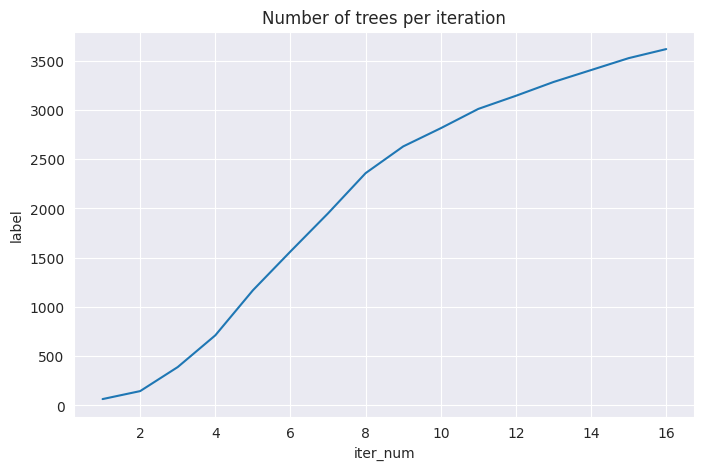

In [196]:
ax = sns.lineplot(data=all_labels_stats,
                  x="iter_num", y="label",
                  estimator="nunique", errorbar=None)

ax.set_title("Number of trees per iteration")

autolabel(ax, "{:.0f}")

plt.show()



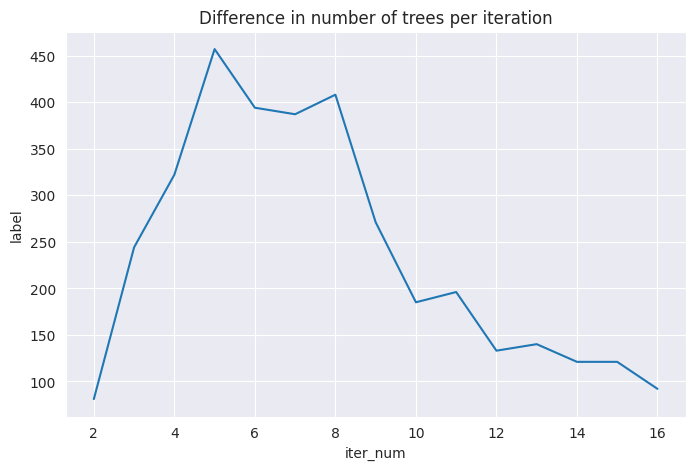

In [205]:
diff_n_labels = all_labels_stats.groupby("iter_num")["label"].nunique().diff()

ax = sns.lineplot(data=diff_n_labels)

ax.set_title("Difference in number of trees per iteration")

plt.show()

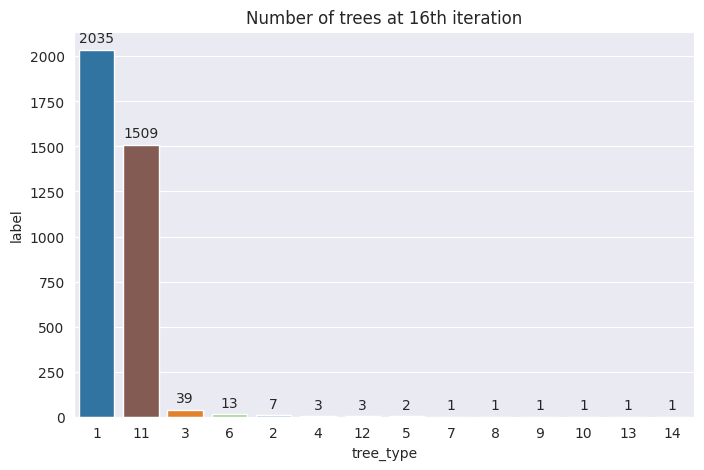

In [206]:
ax = sns.barplot(data=last_iter_stats,
                    x="tree_type", y="label",
                    estimator=lambda group:np.unique(group).shape[0],
                    errorbar=None,
                    order=last_iter_stats.groupby("tree_type")["label"].nunique().sort_values(ascending=False).index,
                    palette=dict_colors["tree_type"])

ax.set_title("Number of trees at 16th iteration")

autolabel(ax, "{:.0f}")

plt.show()

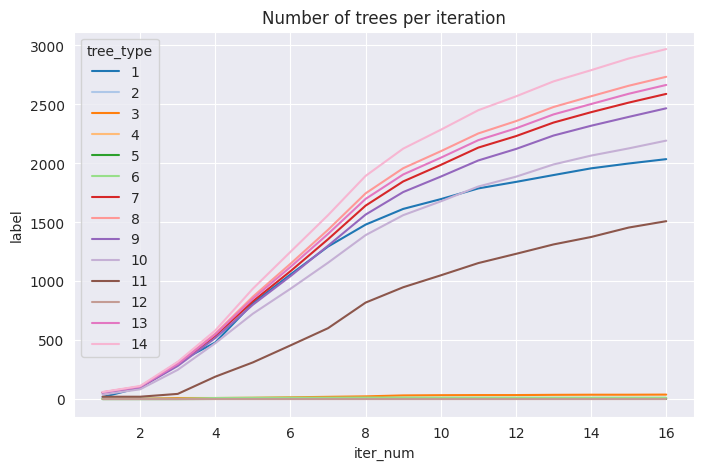

In [173]:
ax = sns.lineplot(
    data=all_labels_stats,
    x="iter_num",
    y="label",
    hue="tree_type",
    estimator=lambda x: x.nunique(),
    errorbar=None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Number of trees per iteration")

plt.show()

# Análise das árvores usadas no treino

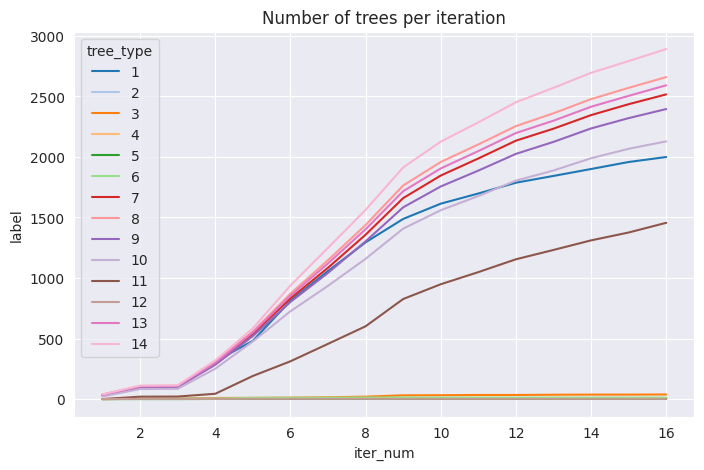

In [188]:
ax = sns.lineplot(
    data=selected_labels_stats,
    x="iter_num",
    y="label",
    hue="tree_type",
    estimator=lambda x: x.nunique(),
    errorbar=None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Number of trees per iteration")

plt.show()